In [1]:
import time

import keras
import keras.backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, LSTM

from ptbdb_cache import load_records

/usr/local/anaconda3/envs/ekg_network/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def pad_sequence(sequence, max_len):
    pad_width = ((0,max_len - sequence.shape[0]), (0, 0))
    
    return np.pad(sequence, pad_width, mode='constant', constant_values=0)

def train_dev_test_set_split(X, Y, fraction=0.15):

    n_holdouts = int(fraction * Y.shape[0])
    
    indices = np.arange(Y.shape[0])
    
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    
    X_train = X[:-2 * n_holdouts]
    X_dev = X[-2 * n_holdouts: -n_holdouts]
    X_test = X[-n_holdouts:]
    
    Y_train = Y[:-2 * n_holdouts]
    Y_dev = Y[-2 * n_holdouts: -n_holdouts]
    Y_test = Y[-n_holdouts:]
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

def get_train_dev_test_sets():
    raw_records = load_records()
    print('finished loading raw records')
    
    records = list(raw_records.values())
    X, Y = zip(*records)

    max_len = max(k.shape[0] for k in X)
    X = np.stack([pad_sequence(xi, max_len) for xi in X])

    print('X shape: {}\n'.format(X.shape))

    print('Y value counts: {}\n'.format(pd.Series(Y).value_counts()))
    Y = np.array([1 if r == 'Myocardial infarction' else 0 for r in Y ]).reshape(-1, 1)
    print('number MIs: {}'.format(np.sum(Y)))
    print('Y shape: {}'.format(Y.shape))

    X_train, X_dev, X_test, Y_train, Y_dev, Y_test = train_dev_test_set_split(X, Y)

    print('X is properly padded: {}'.format(min(k.shape[0] for k in X_train) == max_len))
    print('X_train length: ', len(X_train))
    print('X_dev length: ', len(X_dev))
    print('X_test length: ', len(X_test))

    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = get_train_dev_test_sets()

loading 549 cached ptbdb records
finished loading raw records
X shape: (549, 120012, 15)

Y value counts: Myocardial infarction     368
Healthy control            80
n/a                        27
Cardiomyopathy             17
Bundle branch block        17
Dysrhythmia                16
Hypertrophy                 7
Valvular heart disease      6
Myocarditis                 4
Stable angina               2
Heart failure (NYHA 3)      1
Unstable angina             1
Heart failure (NYHA 4)      1
Palpitation                 1
Heart failure (NYHA 2)      1
dtype: int64

number MIs: 368
Y shape: (549, 1)
X is properly padded: True
X_train length:  385
X_dev length:  82
X_test length:  82


In [3]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [4]:
def get_random_hyperparameters():
    return {
        'num_hidden_units': np.random.randint(4, 100),
        'batch_size': np.random.randint(10, int(len(X_train) / 2)),
        'learning_rate': 10**(-4 * np.random.random())
    }

get_random_hyperparameters()

{'batch_size': 112,
 'learning_rate': 0.01309843022302107,
 'num_hidden_units': 80}

metrics to collect: 
- history (with loss, accuracy, f1 score)
- time to run 10 epochs
- metrics on dev set

In [5]:

def run_model_with_random_hyperparameters(X_train, Y_train, X_dev, Y_dev, n_epochs=5):
    results = {}
    
    hyperparameters = get_random_hyperparameters()
    print('trying parameters: {}'.format(hyperparameters))
    results['hyperparameters'] = hyperparameters
    
    batch_size = hyperparameters['batch_size']
    num_hidden_units = hyperparameters['num_hidden_units']
    learning_rate = hyperparameters['learning_rate']
    
    # Build model
    optimizer = Adam(lr=learning_rate)
    
    model = Sequential([
        LSTM(num_hidden_units, input_shape=X_train[0].shape),
        Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_score])
    
    results['model'] = model
    
    
    # Train model
    t_before = time.time()
    
    history = model.fit(
        X_train, Y_train, 
        batch_size=batch_size, 
        verbose=2, 
        epochs=n_epochs,
    )
    results['history'] = history
    
    t_after = time.time()
    total_time = t_after - t_before
    results['training_time'] = total_time
    
    # Test model
    results['train_metrics'] = model.evaluate(X_train, Y_train, batch_size=batch_size)
    results['dev_metrics'] = model.evaluate(X_dev, Y_dev, batch_size=batch_size)
    
    # Print results
    print('metrics names: ', model.metrics_names)
    print('train_scores: ', results['train_metrics'])
    print('dev_scores: ', results['dev_metrics'])
   
    plt.figure()
    plt.plot(history.history['loss'])
    plt.title(hyperparameters)
    plt.show()
    
    return results





testing model 1 of 5
trying parameters: {'num_hidden_units': 9, 'batch_size': 158, 'learning_rate': 0.0021391288994263907}
Epoch 1/5
 - 431s - loss: 0.7055 - acc: 0.4961 - f1_score: 0.4934
Epoch 2/5
 - 448s - loss: 0.6957 - acc: 0.6987 - f1_score: 0.8132
Epoch 3/5
 - 443s - loss: 0.6870 - acc: 0.7039 - f1_score: 0.8154
Epoch 4/5
 - 461s - loss: 0.6782 - acc: 0.7117 - f1_score: 0.8189
Epoch 5/5
 - 450s - loss: 0.6693 - acc: 0.7221 - f1_score: 0.8252
82/82 [==============================] - 26s 311ms/step
metrics names:  ['loss', 'acc', 'f1_score']
train_scores:  [0.6629810652175507, 0.7298701179492009, 0.8306371371467393]
dev_scores:  [0.673202633857727, 0.6829268336296082, 0.796875]


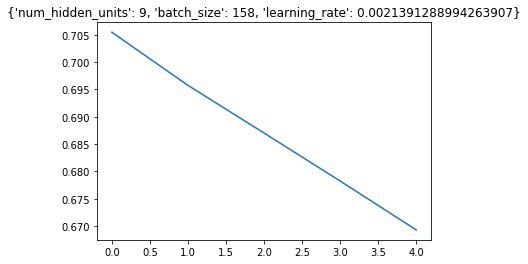


testing model 2 of 5
trying parameters: {'num_hidden_units': 70, 'batch_size': 129, 'learning_rate': 0.00020906765266020852}
Epoch 1/5


In [ ]:
N_MODELS = 5
N_EPOCHS = 5

model_test_results = []
for i in range(N_MODELS):
    print('\ntesting model {} of {}'.format(i + 1, N_MODELS))
    
    try:
        model_result = run_model_with_random_hyperparameters(
            X_train, Y_train, X_dev, Y_dev, 
            n_epochs=N_EPOCHS
        )

        model_test_results.append(model_result)
    except KeyboardInterrupt:
        print('Test Interrupted.')
        break
    
